<a href="https://colab.research.google.com/github/elluy-gabriel-p/Capstone_ML/blob/hapid/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install pillow


In [11]:
# Clone repository dari branch hapid
!git clone --branch hapid https://github.com/elluy-gabriel-p/Capstone_ML.git

# Pastikan dataset berhasil diunduh
!ls Capstone_ML/data/Dataset_makanan_indonesia

# Path dataset untuk digunakan dalam model
DATASET_PATH = '/content/Capstone_ML/data/dataset_padang_food'


fatal: destination path 'Capstone_ML' already exists and is not an empty directory.
'ayam bakar'   bakso  'gado gado'   grontol   lanting   lumpia	 putu_ayu   serabi_solo   wajik


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Parameter dataset
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data Augmentation dan Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotasi gambar
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Distorsi shearing
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest',  # Isi ulang piksel hilang
    validation_split=0.2  # 20% untuk validasi
)

# Path dataset
DATASET_PATH = '/content/Capstone_ML/data/Dataset_makanan_indonesia'

# Load Data Training dan Validation
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 817 images belonging to 9 classes.
Found 201 images belonging to 9 classes.


In [5]:
# Load MobileNetV2 tanpa top layer
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Awalnya freeze semua layer

# Tambahkan layer custom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Regularisasi L2
x = Dropout(0.4)(x)  # Tingkatkan dropout rate
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Kurangi learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fine-tuning: Melatih beberapa layer terakhir dari base_model
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Hanya buka 50 layer terakhir
    layer.trainable = False

# Latih model
EPOCHS = 50
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.1827 - loss: 4.6304 - val_accuracy: 0.5373 - val_loss: 3.7387
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.6476 - loss: 3.4916 - val_accuracy: 0.6517 - val_loss: 3.3228
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8330 - loss: 2.8961 - val_accuracy: 0.6915 - val_loss: 3.1939
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8939 - loss: 2.6720 - val_accuracy: 0.8010 - val_loss: 2.9468
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9029 - loss: 2.5060 - val_accuracy: 0.7761 - val_loss: 2.9195
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9351 - loss: 2.4111 - val_accuracy: 0.8259 - val_loss: 2.7602
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9727 - loss: 2.2824 - val_accuracy: 0.8308 - val_loss: 2.6886
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9608 - loss: 2.2663 - val_accuracy: 0.8358 - val_los

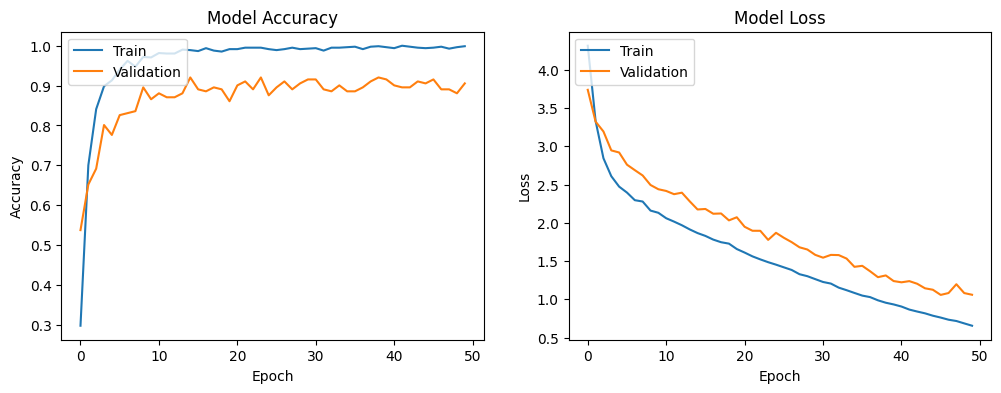

In [6]:
# Monitor Training Progress

import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [7]:
import pandas as pd
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke file CSV kalori di GitHub
CSV_URL = "https://raw.githubusercontent.com/elluy-gabriel-p/Capstone_ML/refs/heads/hapid/dataset_kalori.csv"

# Membaca file CSV
kalori_data = pd.read_csv(CSV_URL)

# Membuat dictionary untuk memetakan makanan ke kalori
kalori_dict = pd.Series(kalori_data['kalori'].values, index=kalori_data['nama_makanan']).to_dict()

# Fungsi untuk prediksi dan menampilkan kalori
def predict_food_and_calories(uploaded_file, model, class_indices, kalori_dict):
    # Load image
    img = image.load_img(uploaded_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi nama makanan
    predictions = model.predict(img_array)
    class_names = list(class_indices.keys())
    predicted_class = class_names[np.argmax(predictions)]

    # Ambil jumlah kalori dari dictionary
    calories = kalori_dict.get(predicted_class, "Kalori tidak ditemukan")

    return predicted_class, calories

# Loop tanpa henti untuk terus mengunggah dan mendeteksi gambar
while True:
    print("Silakan upload gambar makanan untuk deteksi (Tekan Stop Execution untuk keluar):")
    uploaded = files.upload()  # Widget untuk mengunggah gambar

    if uploaded:
        for file_name in uploaded.keys():
            print(f"Processing file: {file_name}")

            # Gunakan model yang telah dilatih
            class_indices = train_data.class_indices

            # Prediksi gambar yang diunggah dan tampilkan hasil
            predicted_food, calories = predict_food_and_calories(file_name, model, class_indices, kalori_dict)
            print(f"The predicted food is: {predicted_food}")
            print(f"Calories: {calories}")


Silakan upload gambar makanan untuk deteksi (Tekan Stop Execution untuk keluar):


Silakan upload gambar makanan untuk deteksi (Tekan Stop Execution untuk keluar):


KeyboardInterrupt: 